# Task7: Equivariant quantum neural networks

We will start by first importing the required libraries

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

First we have to create a dataset of 500 points uniformly sampled in [-1,1]

In [2]:
np.random.seed(42)
N = 500
X = np.random.uniform(-1, 1, (N, 2))

Now we will label each based on the product of x1*x2

Class 1(y=1) if x1*x2>0  <br>
Class 0(y=0) if x1*x2<=0 

Then split the dataset in in training and testing set


In [3]:
y = np.array([1 if x[0]*x[1] > 0 else 0 for x in X])
split = int(0.8 * N)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

## Quantum Neural Network

We will define 2 quantum circuits 

### Standard QNN
A standard quantum circuit that does not explicitly enforce symmetry.

The input x1 x2 are encoded using RX rotation.<br>

`StronglyEntanglingLayers` template is used to add learnable parameters.<br>

Expectation value of the Pauli-Z operator on qubit 0 is used as the output.


In [9]:
num_layers = 3
dev_std = qml.device("default.qubit", wires=2)

def circuit_std(x, weights):
    # Feature encoding
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    # Use a deeper, more expressive circuit:
    qml.templates.StronglyEntanglingLayers(weights, wires=[0, 1])
    return qml.expval(qml.PauliZ(0))

weights_std = np.random.randn(num_layers, 2, 3, requires_grad=True)
qnode_std = qml.QNode(circuit_std, dev_std, interface="autograd")

## Equivariant QNN

A quantum circuit that enforces symmetric split

Feature Encoding same as standard QNN

Apply same rotation to both layers

The IsingXX gate is used as a symmetric entangler.

In [7]:
dev_eq = qml.device("default.qubit", wires=2)

def circuit_eq(x, weights):
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    
    for i in range(num_layers):
        
        qml.RY(weights[i, 0], wires=0)
        qml.RY(weights[i, 0], wires=1)
        
        qml.IsingXX(weights[i, 1], wires=[0, 1])

        qml.RY(weights[i, 2], wires=0)
        qml.RY(weights[i, 2], wires=1)
    return qml.expval(qml.PauliZ(0))

# shape should be (num_layers, 3)
weights_eq = np.random.randn(num_layers, 3, requires_grad=True)
qnode_eq = qml.QNode(circuit_eq, dev_eq, interface="autograd")

## Prediction and Cost Function

The Binary Cross-Entropy (BCE) loss is defined as:

$$
\mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$

where:
- N is the number of samples,
- ( y_i in {0,1}) is the true label of the i -th sample,
- ( \hat{y}_i ) is the predicted probability of the positive class.



In [8]:
def predict_std(x, weights):
    # Map expectation value [-1,1] to probability [0,1]
    return (qnode_std(x, weights) + 1) / 2

def predict_eq(x, weights):
    return (qnode_eq(x, weights) + 1) / 2

def cost_std(weights, X, y):
    loss = 0
    for i in range(len(X)):
        p = predict_std(X[i], weights)
        loss += - (y[i] * np.log(p + 1e-6) + (1 - y[i]) * np.log(1 - p + 1e-6))
    return loss / len(X)

def cost_eq(weights, X, y):
    loss = 0
    for i in range(len(X)):
        p = predict_eq(X[i], weights)
        loss += - (y[i] * np.log(p + 1e-6) + (1 - y[i]) * np.log(1 - p + 1e-6))
    return loss / len(X)

## Training the Models

Both models are trained using the Adam optimizer with a learning rate of 0.05 for 60 epochs.


In [10]:
opt_std = qml.AdamOptimizer(stepsize=0.05)
opt_eq = qml.AdamOptimizer(stepsize=0.05)
epochs = 60

losses_std = []
losses_eq = []


for it in range(epochs):
    weights_std = opt_std.step(lambda w: cost_std(w, X_train, y_train), weights_std)
    weights_eq = opt_eq.step(lambda w: cost_eq(w, X_train, y_train), weights_eq)
    losses_std.append(cost_std(weights_std, X_train, y_train))
    losses_eq.append(cost_eq(weights_eq, X_train, y_train))
    if it % 30 == 0:
        print(f"Epoch {it:3d} | Standard Loss: {losses_std[-1]:.4f} | Equivariant Loss: {losses_eq[-1]:.4f}")

Epoch   0 | Standard Loss: 0.7104 | Equivariant Loss: 0.7397
Epoch  30 | Standard Loss: 0.5075 | Equivariant Loss: 0.6858


Performance Check and plot 

We will now compute the accuracy on the test data and then plot the loss curves


Test Accuracy (Improved Models):
Standard QNN:      0.85
Equivariant QNN:   0.44


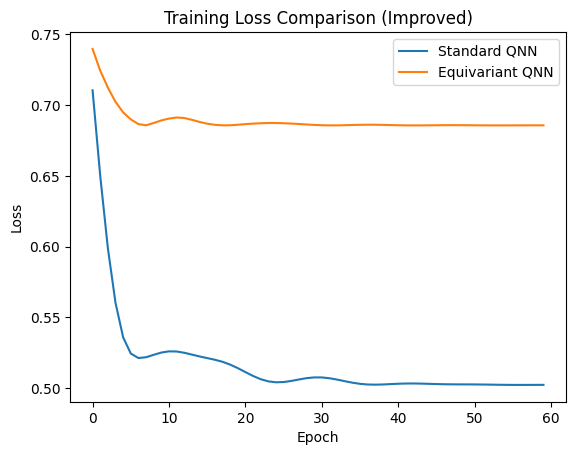

In [11]:
def accuracy_std(weights, X, y):
    preds = [1 if predict_std(x, weights) >= 0.5 else 0 for x in X]
    return np.mean(np.array(preds) == y)

def accuracy_eq(weights, X, y):
    preds = [1 if predict_eq(x, weights) >= 0.5 else 0 for x in X]
    return np.mean(np.array(preds) == y)

acc_std = accuracy_std(weights_std, X_test, y_test)
acc_eq = accuracy_eq(weights_eq, X_test, y_test)

print("\nTest Accuracy (Improved Models):")
print("Standard QNN:     ", acc_std)
print("Equivariant QNN:  ", acc_eq)

# Plot training loss curves
plt.plot(losses_std, label="Standard QNN")
plt.plot(losses_eq, label="Equivariant QNN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Comparison (Improved)")
plt.show()

### Output 

This output signifies that the Standard QNN significantly outperforms the Equivariant QNN in terms of test accuracy on this particular dataset.

Standard QNN (Blue Line):<br>
The loss decreases rapidly in the first few epochs and continues to decline steadily, stabilizing at a low value.
This suggests that it is learning the classification task well.


Equivariant QNN (Orange Line):<br>
The loss remains high and fluctuates without significant improvement.
This indicates that the equivariant QNN is struggling to learn the decision boundary effectively.
